<a href="https://colab.research.google.com/github/pachterlab/BLCSBGLKP_2020/blob/master/notebooks/lod_fda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!date

Fri Jun 26 18:06:31 UTC 2020


In [2]:
!git clone https://github.com/pachterlab/BLCSBGLKP_2020.git

Cloning into 'BLCSBGLKP_2020'...
remote: Enumerating objects: 228, done.
remote: Counting objects: 100% (228/228), done.
remote: Compressing objects: 100% (209/209), done.
remote: Total 228 (delta 83), reused 85 (delta 14), pack-reused 0
Receiving objects: 100% (228/228), 41.99 MiB | 11.40 MiB/s, done.
Resolving deltas: 100% (83/83), done.


In [3]:
!pip install anndata

     |████████████████████████████████| 122kB 2.7MB/s 


# LOD as defined by the FDA 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import anndata

from collections import defaultdict
from collections import OrderedDict


from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import matplotlib.patches as mpatches



from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.special import expit as sigmoid

def nd(arr):
    return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

cm = {1:"#D43F3A", 0:"#3182bd"}
fsize=17

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [5]:
def logreg(X, y1, y2, state=0, return_score=False):
    y = np.asarray([y1, y2]).T
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=state)
    clf = LogisticRegression(dual=False, max_iter=10000, tol=1e-6)
    clf.fit(X_train, y_train[:,0])

    y_pred = clf.predict(X_test)
    
    # T = True, F = False, P = Positive,  N = Negative
    # Model Precision: TP/(TP+FP)
    # Model Recall: TP/(TP+FN)
    
    if return_score:
        score = clf.score(X_test, y_test[:,0].astype(int))
        precision = metrics.precision_score(y_test[:,0].astype(int), y_pred.astype(int))
        recall = metrics.recall_score(y_test[:,0].astype(int), y_pred.astype(int))
        return (score, precision, recall)
    
    w = clf.coef_[0]
    b = clf.intercept_[0]

    return (X_train, X_test, y_train, y_test, y_pred, w, b)

In [6]:
def bplot(x, y, ax):
    parts = ax.boxplot(
        y, positions=x, widths=0.5)
    
    for i, j in zip(x,y):
        xx = np.random.normal(i, 0.04, size=len(j))
        ax.scatter(xx, j, color="k", s=1)
        
    mean = np.array(y).mean(axis=1)
    ax.scatter(x, mean, color="#D43F3A")
    return ax

In [7]:
kb_raw = anndata.read_h5ad("BLCSBGLKP_2020/data/kb/adata.h5ad")

Plate2	HEK293	S2	Twist

In [8]:
a = np.logical_and.reduce([(kb_raw.obs.plate=="Plate2").values, (kb_raw.obs.lysate=="HEK293").values, kb_raw.obs.Twist_bool.values])
m = np.logical_or.reduce([kb_raw.var.gene.values=="RPP30", kb_raw.var.gene.values=="S2", kb_raw.var.gene.values=="S2_spikein"])

kb = kb_raw[a][:,m]

In [9]:
kb

View of AnnData object with n_obs × n_vars = 96 × 3
    obs: 'bcs', 'ecs', 'cnt', 'plate', 'well', 'lysate', 'Twist', 'ATCC_RNA', 'ATCC_viral', 'Twist_bool', 'ATCC_viral_bool', 'ATCC_RNA_bool'
    var: 'gene'
    obsm: 'X_pca'
    layers: 'log1p', 'norm', 'raw', 'scale'

In [10]:
mtx = np.log1p(kb.layers["raw"])
genes = kb.var.gene.values
assignments = kb.obs.Twist.values
sick = (kb.obs.Twist>0).astype(int).values

In [11]:
unique = np.unique(assignments)

In [12]:
states = np.array([ 487,  942,  202,  736,  873,  331,   35,  208,  196,   96,  510,
                      0,  687,  665,  700,  786,  190,  240,  401,  800,  307,  473,
                      3,  635,  993,  985,  448,  259,  541,  283,  214,  277,  113,
                    679,  637,  416,  258, 1019,  236,  527,  289,  326,  291, 1018,
                    701,  263,  812,  607,  251,   82,  961,  920, 1003,  725,  261,
                    582,  609,  524,  731,  143,  717,  161,  602,   45,  154,  369,
                    989,  896,  754,  946,  261,  224,  595,  750,  722,  542,  208,
                     12,  293,  479,  679,  879,  364,   66,  477,  602,  905,  704,
                    673,  111,  968,  517,  873,  263,  257,    6, 1022,  268,  178])

In [13]:
%%time
s = []
p = []
r = []
n=99
for uidx, u in enumerate(unique[:-1]):
    l = [assignments==unique[i] for i in range(uidx, len(unique))]
    if len(l)!=0:
        m = np.logical_or.reduce(l)
        m = np.logical_or(m, assignments==unique[0])
    else:
        m = [True]*len(assignments)

    X = mtx[m]
    y1 = sick[m]
    y2 = assignments[m]
    # if uidx==0:
    #     break
    s_tmp = []
    p_tmp = []
    r_tmp = []
    for i in range(n):
        score, precision, recall = logreg(X, y1, y2, states[i], True)
        s_tmp.append(score)
        p_tmp.append(precision)
        r_tmp.append(recall)
    s.append(s_tmp)
    p.append(p_tmp)
    r.append(r_tmp)

CPU times: user 6.2 s, sys: 17.9 ms, total: 6.21 s
Wall time: 6.21 s


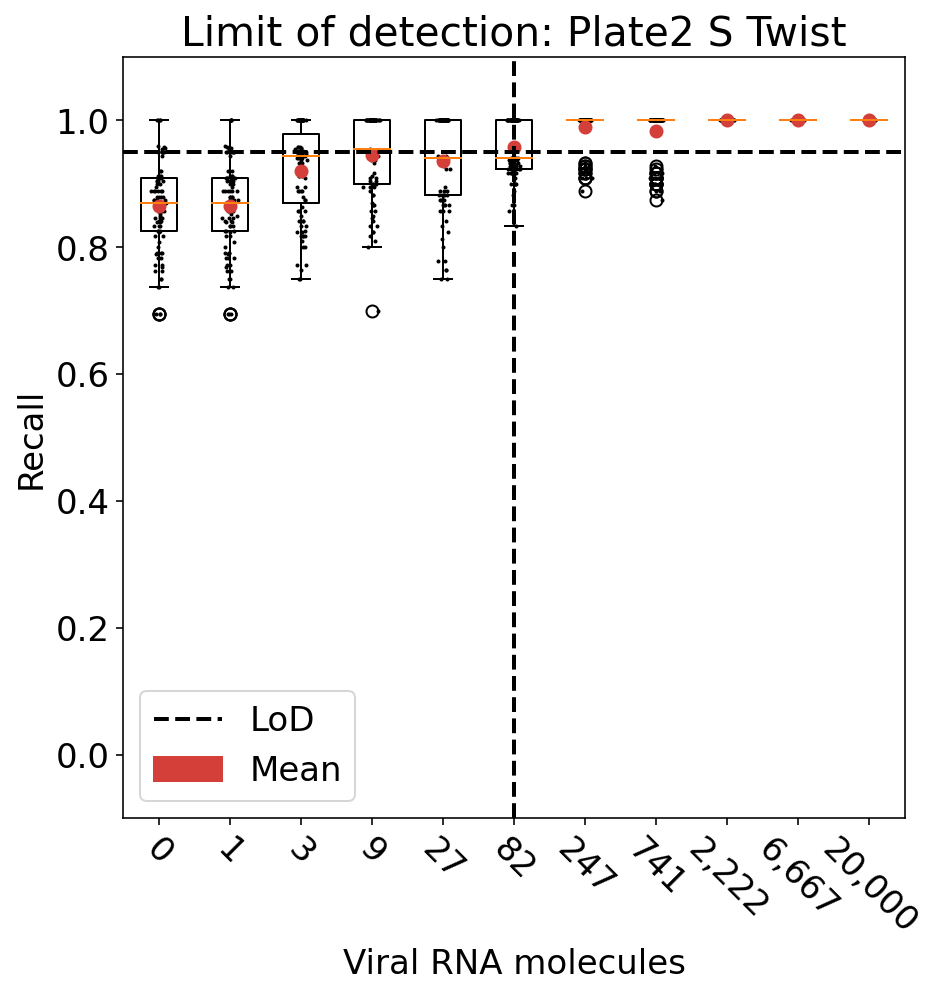

In [14]:
fig, ax = plt.subplots(figsize=(7,7))
x = unique[:-1]
xlabels = unique[:-1]
xidx = np.arange(xlabels.shape[0])
y = r

bplot(xidx, y, ax)


approved = np.where(np.array(r).mean(axis=1)>=0.95)[0][0]
ax.axvline(x=xidx[approved],linestyle="--", linewidth=2, color="k")
lod = ax.axhline(y=0.95, linestyle="--", linewidth=2, color="k", label="LoD")

fmt = lambda x: "{:,.0f}".format(x)
ax.set_xticklabels([fmt(i) for i in x], ha="center", rotation=-45)
ax.set_xlabel("Viral RNA molecules")
ax.set_ylabel("Recall")
ax.set_ylim((-0.1, 1.1))
ax.legend()

mean = mpatches.Patch(color="#D43F3A", label='Mean')
ax.legend(handles=[lod, mean])
ax.set_title("Limit of detection: {} {} {}".format("Plate2", "S", "Twist"))
#plt.savefig("./figs/recall_{}_{}_{}.png".format("Plate2", "S2", "Twist"),bbox_inches='tight', dpi=300)

plt.show()

# Other experiments

Plate2	HEK293	S2	ATCC_RNA

In [15]:
a = np.logical_and.reduce([(kb_raw.obs.plate=="Plate2").values, (kb_raw.obs.lysate=="HEK293").values, kb_raw.obs.ATCC_RNA_bool.values])
m = np.logical_or.reduce([kb_raw.var.gene.values=="RPP30", kb_raw.var.gene.values=="S2", kb_raw.var.gene.values=="S2_spikein"])

kb = kb_raw[a][:,m]

In [16]:
kb

View of AnnData object with n_obs × n_vars = 140 × 3
    obs: 'bcs', 'ecs', 'cnt', 'plate', 'well', 'lysate', 'Twist', 'ATCC_RNA', 'ATCC_viral', 'Twist_bool', 'ATCC_viral_bool', 'ATCC_RNA_bool'
    var: 'gene'
    obsm: 'X_pca'
    layers: 'log1p', 'norm', 'raw', 'scale'

In [17]:
mtx = np.log1p(kb.layers["raw"])
genes = kb.var.gene.values
assignments = kb.obs.ATCC_RNA.values
sick = (kb.obs.ATCC_RNA>0).astype(int).values

In [18]:
unique = np.unique(assignments)

In [19]:
exp = ("Plate2", "S", "ATCC_RNA")

In [20]:
%%time
s = []
p = []
r = []
n=99
for uidx, u in enumerate(unique[:-1]):
    l = [assignments==unique[i] for i in range(uidx, len(unique))]
    if len(l)!=0:
        m = np.logical_or.reduce(l)
        m = np.logical_or(m, assignments==unique[0])
    else:
        m = [True]*len(assignments)

    X = mtx[m]
    y1 = sick[m]
    y2 = assignments[m]
    # if uidx==0:
    #     break
    s_tmp = []
    p_tmp = []
    r_tmp = []
    for i in range(n):
        score, precision, recall = logreg(X, y1, y2, states[i], True)
        s_tmp.append(score)
        p_tmp.append(precision)
        r_tmp.append(recall)
    s.append(s_tmp)
    p.append(p_tmp)
    r.append(r_tmp)

CPU times: user 6.37 s, sys: 10.9 ms, total: 6.38 s
Wall time: 6.38 s


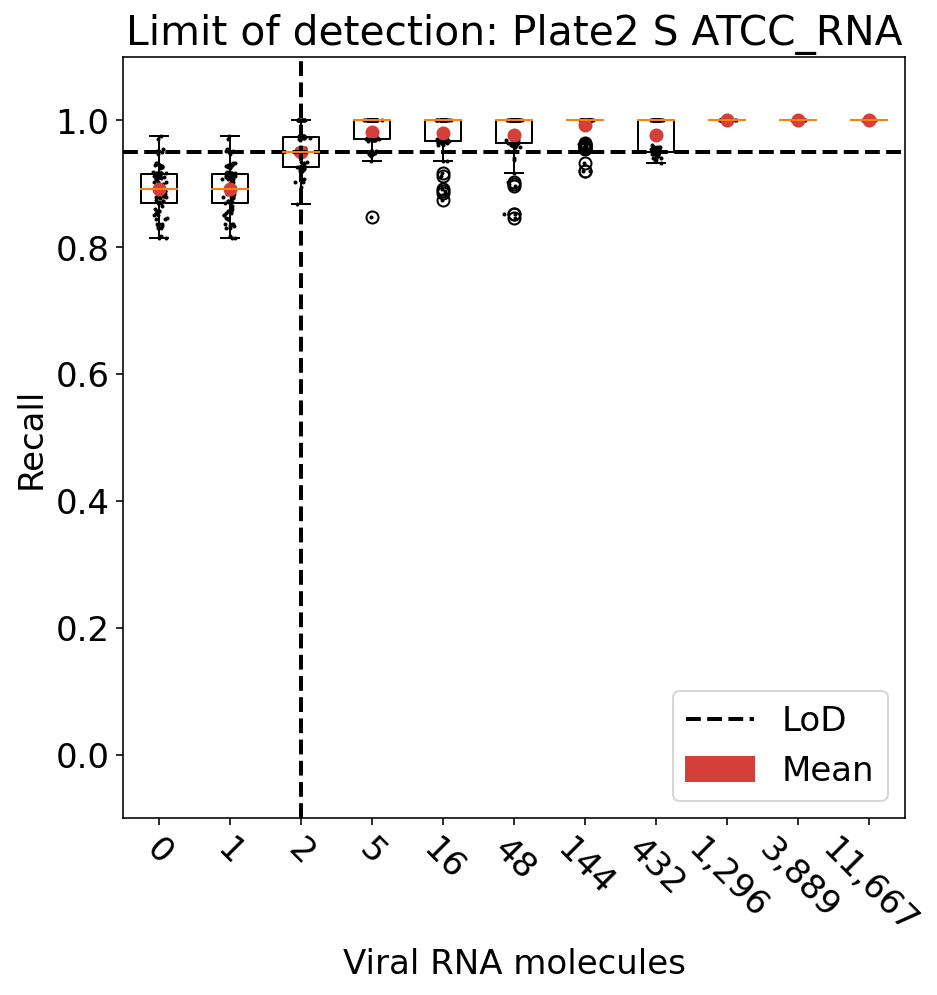

In [21]:
fig, ax = plt.subplots(figsize=(7,7))
x = unique[:-1]
xlabels = unique[:-1]
xidx = np.arange(xlabels.shape[0])
y = r

bplot(xidx, y, ax)

approved = np.where(np.array(r).mean(axis=1)>=0.95)[0][0]
ax.axvline(x=xidx[approved],linestyle="--", linewidth=2, color="k")
lod = ax.axhline(y=0.95, linestyle="--", linewidth=2, color="k", label="LoD")

fmt = lambda x: "{:,.0f}".format(x)
ax.set_xticklabels([fmt(i) for i in x], ha="center", rotation=-45)
ax.set_xlabel("Viral RNA molecules")
ax.set_ylabel("Recall")
ax.set_ylim((-0.1, 1.1))
ax.legend()

mean = mpatches.Patch(color="#D43F3A", label='Mean')
ax.legend(handles=[lod, mean])
ax.set_title("Limit of detection: {} {} {}".format(*exp))
#plt.savefig("./figs/recall_{}_{}_{}.png".format(*exp),bbox_inches='tight', dpi=300)

plt.show()

Plate1	HEK293	N1	ATCC_RNA

In [22]:
a = np.logical_and.reduce([(kb_raw.obs.plate=="Plate1").values, (kb_raw.obs.lysate=="HEK293").values, kb_raw.obs.ATCC_RNA_bool.values])
m = np.logical_or.reduce([kb_raw.var.gene.values=="RPP30", kb_raw.var.gene.values=="N1", kb_raw.var.gene.values=="N1_spikein"])

kb = kb_raw[a][:,m]

In [23]:
kb

View of AnnData object with n_obs × n_vars = 140 × 3
    obs: 'bcs', 'ecs', 'cnt', 'plate', 'well', 'lysate', 'Twist', 'ATCC_RNA', 'ATCC_viral', 'Twist_bool', 'ATCC_viral_bool', 'ATCC_RNA_bool'
    var: 'gene'
    obsm: 'X_pca'
    layers: 'log1p', 'norm', 'raw', 'scale'

In [24]:
mtx = np.log1p(kb.layers["raw"])
genes = kb.var.gene.values
assignments = kb.obs.ATCC_RNA.values
sick = (kb.obs.ATCC_RNA>0).astype(int).values

In [25]:
unique = np.unique(assignments)

In [26]:
exp = ("Plate1", "N", "ATCC_RNA")

In [27]:
%%time
s = []
p = []
r = []
n=99
for uidx, u in enumerate(unique[:-1]):
    l = [assignments==unique[i] for i in range(uidx, len(unique))]
    if len(l)!=0:
        m = np.logical_or.reduce(l)
        m = np.logical_or(m, assignments==unique[0])
    else:
        m = [True]*len(assignments)

    X = mtx[m]
    y1 = sick[m]
    y2 = assignments[m]
    # if uidx==0:
    #     break
    s_tmp = []
    p_tmp = []
    r_tmp = []
    for i in range(n):
        score, precision, recall = logreg(X, y1, y2, states[i], True)
        s_tmp.append(score)
        p_tmp.append(precision)
        r_tmp.append(recall)
    s.append(s_tmp)
    p.append(p_tmp)
    r.append(r_tmp)

CPU times: user 6.93 s, sys: 12.9 ms, total: 6.94 s
Wall time: 6.96 s


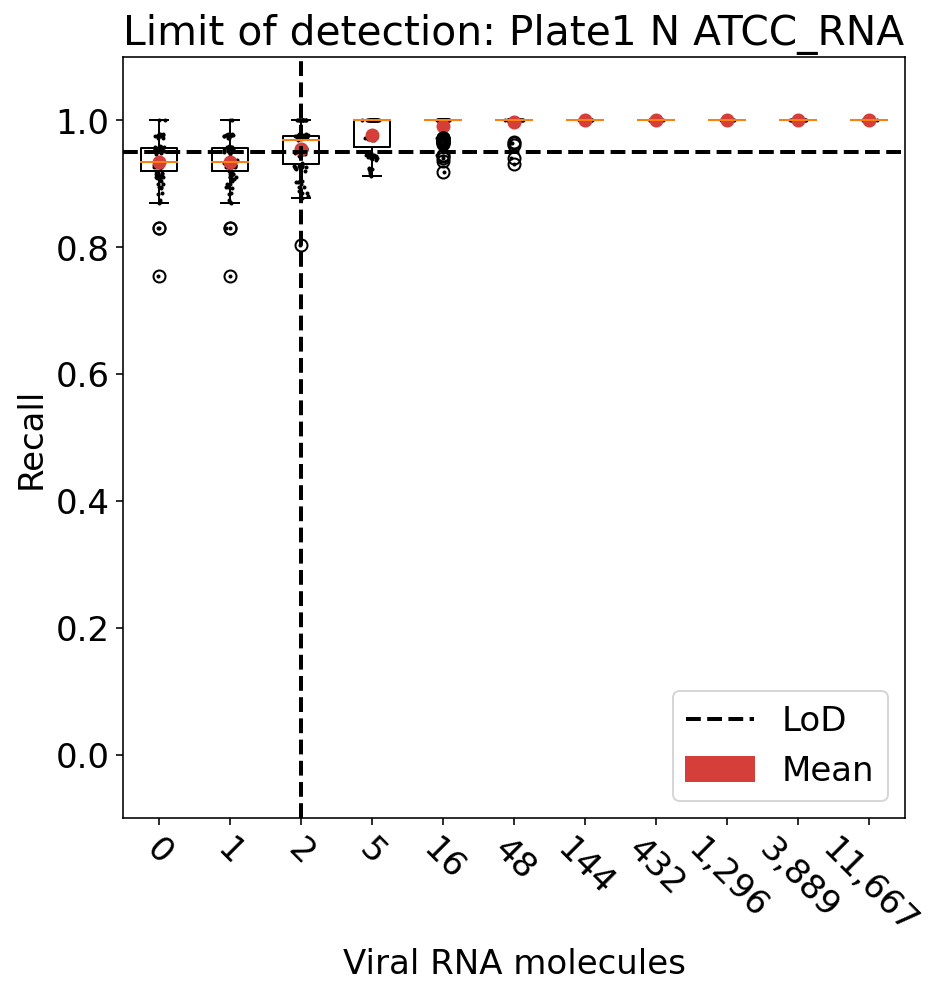

In [28]:
fig, ax = plt.subplots(figsize=(7,7))
x = unique[:-1]
xlabels = unique[:-1]
xidx = np.arange(xlabels.shape[0])
y = r

bplot(xidx, y, ax)

approved = np.where(np.array(r).mean(axis=1)>=0.95)[0][0]
ax.axvline(x=xidx[approved],linestyle="--", linewidth=2, color="k")
lod = ax.axhline(y=0.95, linestyle="--", linewidth=2, color="k", label="LoD")

fmt = lambda x: "{:,.0f}".format(x)
ax.set_xticklabels([fmt(i) for i in x], ha="center", rotation=-45)
ax.set_xlabel("Viral RNA molecules")
ax.set_ylabel("Recall")
ax.set_ylim((-0.1, 1.1))
ax.legend()

mean = mpatches.Patch(color="#D43F3A", label='Mean')
ax.legend(handles=[lod, mean])
ax.set_title("Limit of detection: {} {} {}".format(*exp))
#plt.savefig("./figs/recall_{}_{}_{}.png".format(*exp),bbox_inches='tight', dpi=300)

plt.show()

Plate1	HEK293	N1	Twist

In [29]:
a = np.logical_and.reduce([(kb_raw.obs.plate=="Plate1").values, (kb_raw.obs.lysate=="HEK293").values, kb_raw.obs.Twist_bool.values])
m = np.logical_or.reduce([kb_raw.var.gene.values=="RPP30", kb_raw.var.gene.values=="N1", kb_raw.var.gene.values=="N1_spikein"])

kb = kb_raw[a][:,m]

In [30]:
kb

View of AnnData object with n_obs × n_vars = 96 × 3
    obs: 'bcs', 'ecs', 'cnt', 'plate', 'well', 'lysate', 'Twist', 'ATCC_RNA', 'ATCC_viral', 'Twist_bool', 'ATCC_viral_bool', 'ATCC_RNA_bool'
    var: 'gene'
    obsm: 'X_pca'
    layers: 'log1p', 'norm', 'raw', 'scale'

In [31]:
mtx = np.log1p(kb.layers["raw"])
genes = kb.var.gene.values
assignments = kb.obs.Twist.values
sick = (kb.obs.Twist>0).astype(int).values

In [32]:
unique = np.unique(assignments)

In [33]:
exp = ("Plate1", "N", "Twist")

In [34]:
%%time
s = []
p = []
r = []
n=99
for uidx, u in enumerate(unique[:-1]):
    l = [assignments==unique[i] for i in range(uidx, len(unique))]
    if len(l)!=0:
        m = np.logical_or.reduce(l)
        m = np.logical_or(m, assignments==unique[0])
    else:
        m = [True]*len(assignments)

    X = mtx[m]
    y1 = sick[m]
    y2 = assignments[m]
    # if uidx==0:
    #     break
    s_tmp = []
    p_tmp = []
    r_tmp = []
    for i in range(n):
        score, precision, recall = logreg(X, y1, y2, states[i], True)
        s_tmp.append(score)
        p_tmp.append(precision)
        r_tmp.append(recall)
    s.append(s_tmp)
    p.append(p_tmp)
    r.append(r_tmp)

CPU times: user 6.74 s, sys: 11.8 ms, total: 6.75 s
Wall time: 6.76 s


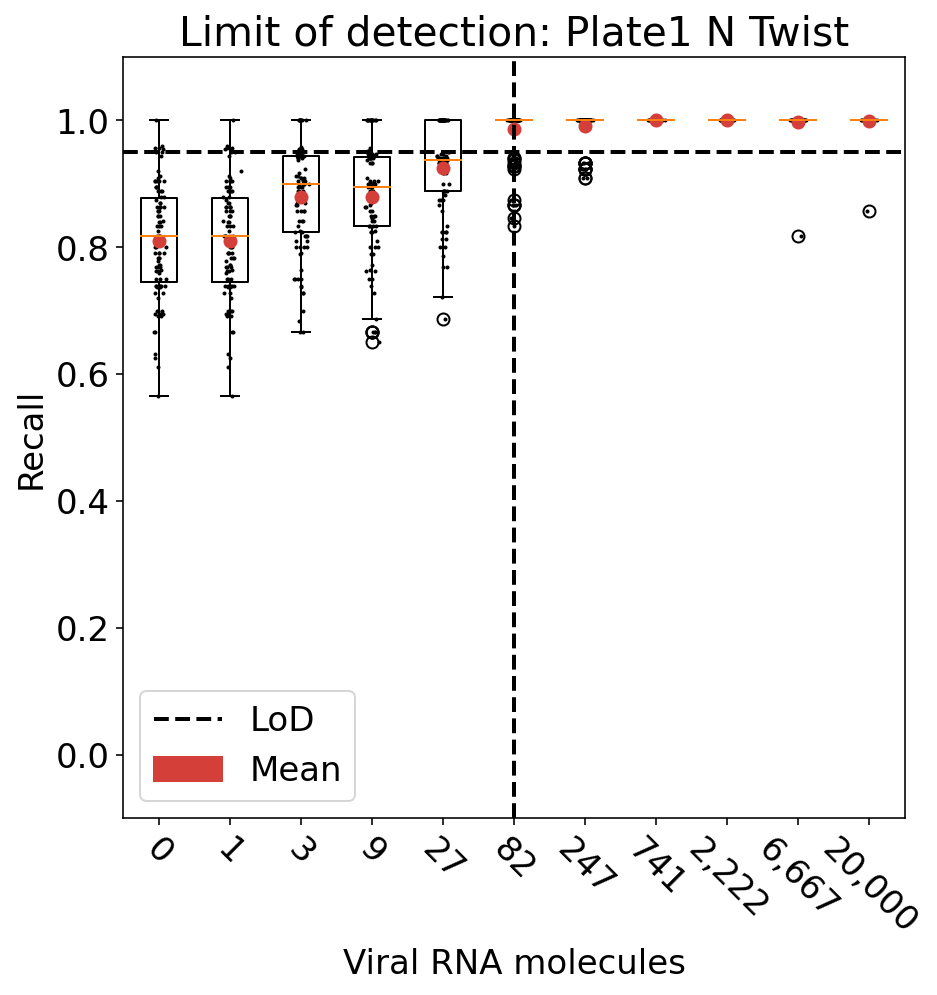

In [35]:
fig, ax = plt.subplots(figsize=(7,7))
x = unique[:-1]
xlabels = unique[:-1]
xidx = np.arange(xlabels.shape[0])
y = r

bplot(xidx, y, ax)

approved = np.where(np.array(r).mean(axis=1)>=0.95)[0][0]
ax.axvline(x=xidx[approved],linestyle="--", linewidth=2, color="k")
lod = ax.axhline(y=0.95, linestyle="--", linewidth=2, color="k", label="LoD")

fmt = lambda x: "{:,.0f}".format(x)
ax.set_xticklabels([fmt(i) for i in x], ha="center", rotation=-45)
ax.set_xlabel("Viral RNA molecules")
ax.set_ylabel("Recall")
ax.set_ylim((-0.1, 1.1))
ax.legend()

mean = mpatches.Patch(color="#D43F3A", label='Mean')
ax.legend(handles=[lod, mean])
ax.set_title("Limit of detection: {} {} {}".format(*exp))
# plt.savefig("./figs/recall_{}_{}_{}.png".format(*exp),bbox_inches='tight', dpi=300)

plt.show()

In [36]:
!date

Fri Jun 26 18:07:22 UTC 2020
